In [1]:
import pandas as pd
import numpy as np

In [47]:
items = pd.read_csv('items.csv')

In [3]:
ratings = pd.read_csv('ratings.csv')

In [4]:
cbf = pd.read_csv('cbf.csv')

In [5]:
item_item = pd.read_csv('item-item.csv')

In [6]:
user_user = pd.read_csv('user-user.csv')

In [7]:
pers_bias = pd.read_csv('pers-bias.csv')

In [8]:
mf = pd.read_csv('mf.csv')

In [9]:
recs = [cbf, item_item, user_user, pers_bias, mf]
recs_names = ['cbf', 'item_item', 'user_user', 'pers_bias', 'mf']

# Helper functions

In [10]:
def get_ratings(user_id):
    user_ratings = ratings[user_id]
    actual_ratings = user_ratings[~np.isnan(user_ratings)]
    return actual_ratings

In [11]:
def get_top_n(user_id, n):
    top_n = {}
    for rec, rec_name in zip(recs, recs_names):
        top_n_items = rec[user_id].argsort().sort_values()[:n].index.values
        top_n[rec_name] = top_n_items
    return top_n

In [12]:
def get_popular_items(n):
    pop_percentages = ratings.copy()
    pop_percentages['popularity'] = ratings.apply(lambda row: np.sum(~np.isnan(row))-1, axis=1)/len(ratings.columns[1::])
    pop_percentages = pop_percentages.sort_values(by = 'popularity', ascending=False)
    return pop_percentages.item.values[:n]

# RMSE

In [13]:
def get_rmse(user_id):   
    user_ratings = get_ratings(user_id)
    rmse = {}
    for rec, rec_name in zip(recs, recs_names):
        predicted_ratings = rec.loc[user_ratings.index, user_id]
        temp = np.sqrt(np.average((predicted_ratings - user_ratings)**2))
        rmse[rec_name] = temp
    return rmse

# Precision @ N

In [14]:
def get_precision_at_n(user_id, n):
    top_n = get_top_n(user_id, n)
    user_ratings = get_ratings(user_id).index.values
    precisions = {}
    for rec, rec_name in zip(recs, recs_names):
        temp = np.sum(np.isin(top_n[rec_name], user_ratings))/n
        precisions[rec_name] = temp
    return precisions

# Product Diversity

In [15]:
# We will use the "FullCat" column in the items catalog to determine the product diversity in the recommendations.
# The recommender with a high number of distinct product categories in its recommendations is said to be product-diverse
def get_product_diversity(user_id, n):
    top_n = get_top_n(user_id, n)
    product_diversity = {}
    for rec_name in top_n:
        categories = items.loc[top_n[rec_name]][['FullCat']].values
        categories = set([item for sublist in categories for item in sublist])
        product_diversity[rec_name] = len(categories)
    return product_diversity

# Cost Diversity

In [16]:
# We will use the "Price" column in the items catalog to determine cost diversity in the recommendations.
# The recommender with a high standard deviation in the cost across all its recommendations is said to be cost-diverse
def get_cost_diversity(user_id, n):
    top_n = get_top_n(user_id,n)
    cost_diversity = {}
    for rec_name in top_n:
        std_dev = np.std(items.loc[top_n[rec_name]][['Price']].values)
        cost_diversity[rec_name] = std_dev
    return cost_diversity

# Serendipity

In [17]:
# We will use inverse popularity as a measure of serendipity.
# The recommender with least number of recommendations on the "most popular" list, will be called most serendipitous
def get_serendipity(user_id, n):
    top_n = get_top_n(user_id,n)
    popular_items = get_popular_items(20)
    serendipity = {}
    for rec, rec_name in zip(recs, recs_names):
        popularity = np.sum(np.isin(top_n[rec_name],popular_items))
        if int(popularity) == 0:
            serendipity[rec_name] = 1
        else:
            serendipity[rec_name] = 1/popularity
    return serendipity

# Average metrics

In [18]:
avg_metrics = {}
for name in recs_names: 
    avg_metrics[name] = {"rmse": [], "precision_at_n": [], "product_diversity": [], "cost_diversity": [], "serendipity": []}

for user_id in ratings.columns:
    if user_id == 'item':
        continue
    user_id = str(user_id)
    rmse = get_rmse(user_id)
    precision_at_n = get_precision_at_n(user_id, 10)
    product_diversity = get_product_diversity(user_id, 10)
    cost_diversity = get_cost_diversity(user_id, 10)
    serendipity = get_serendipity(user_id, 10)
    for key in avg_metrics:
        rec_name = avg_metrics[key]
        rec_name['rmse'].append(rmse[key])
        rec_name['precision_at_n'].append(precision_at_n[key])
        rec_name['product_diversity'].append(product_diversity[key])
        rec_name['cost_diversity'].append(cost_diversity[key])
        rec_name['serendipity'].append(serendipity[key])

# The Price for certain items is not available. Also rmse for certain users is turning out to be NaN.
# Ignoring nans in the average metric calculation for now. So basically narrowing down the evaluation to users who have
# rated atleast one item and items for which the price is known.
for key in avg_metrics:
    rec_name = avg_metrics[key]
    for metric in rec_name:
        temp = rec_name[metric]
        temp = [x for x in temp if not np.isnan(x)]
        rec_name[metric] = sum(temp) / len(temp)

In [19]:
avg_metrics

{'cbf': {'rmse': 0.5723872810703614,
  'precision_at_n': 0.06099999999999995,
  'product_diversity': 9.16,
  'cost_diversity': 21.001285934775364,
  'serendipity': 1.0},
 'item_item': {'rmse': 0.574672000873145,
  'precision_at_n': 0.073,
  'product_diversity': 9.29,
  'cost_diversity': 28.369414026218912,
  'serendipity': 1.0},
 'user_user': {'rmse': 0.5451297974933205,
  'precision_at_n': 0.06799999999999996,
  'product_diversity': 9.09,
  'cost_diversity': 26.861774672518923,
  'serendipity': 1.0},
 'pers_bias': {'rmse': 0.6662727799419501,
  'precision_at_n': 0.07499999999999996,
  'product_diversity': 10.0,
  'cost_diversity': 5.4132984399532225,
  'serendipity': 1.0},
 'mf': {'rmse': 0.6590287674772085,
  'precision_at_n': 0.08199999999999996,
  'product_diversity': 9.23,
  'cost_diversity': 38.535530124652226,
  'serendipity': 1.0}}

# Hybridization

In [20]:
# Creating a dataframe with ratings from all algorithms and user_ratings as ground truth
users = []
items = []
user_ratings = []
cbf_ratings = []
user_user_ratings = []
item_item_ratings = []
mf_ratings = []
pers_bias_ratings = []

for user_id in ratings.columns:
    if user_id == 'item':
        continue
    user_id = str(user_id)
    true_ratings = get_ratings(user_id)
    user_ratings.extend(true_ratings.values)
    users.extend([user_id]*len(true_ratings))
    items.extend(ratings.loc[true_ratings.index].item.values)
    cbf_ratings.extend(cbf.loc[true_ratings.index, user_id].values)
    item_item_ratings.extend(item_item.loc[true_ratings.index, user_id].values)
    user_user_ratings.extend(user_user.loc[true_ratings.index, user_id].values)
    pers_bias_ratings.extend(pers_bias.loc[true_ratings.index, user_id].values)
    mf_ratings.extend(mf.loc[true_ratings.index, user_id].values)
    
df = pd.DataFrame({'user': users, 'item': items,'true_rating': user_ratings, 'cbf':cbf_ratings, 'item_item':item_item_ratings, 'user_user': user_user_ratings, 'pers_bias':pers_bias_ratings, 'mf':mf_ratings})

In [21]:
df = df.dropna()

In [22]:
df.head()

,user,item,true_rating,cbf,item_item,user_user,pers_bias,mf
0,64,72,4.0,4.204670,4.020528,3.997032,4.221597,4.293189
1,64,1240,5.0,4.784942,4.850921,4.962889,4.659690,4.703951
2,64,1300,4.0,4.522897,4.538863,4.111147,4.613524,4.653262
3,64,1317,5.0,4.721176,4.687212,5.040519,4.657269,4.675896
4,64,1327,3.0,4.368981,4.321261,4.460465,4.352745,4.358705


## Linear Combination

### Performance

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
clf = LinearRegression()

In [25]:
# Split data in 80-20 train and test sets
train = df[0:(int(0.8*len(df)))]
test = df[(int(0.8*len(df)))::]

In [26]:
train_data = train.drop(['user', 'item','true_rating'], axis=1)
train_labels = train.true_rating.values
model = clf.fit(train_data, train_labels)

In [27]:
test_data = test.drop(['user', 'item','true_rating'], axis=1)
test_labels = test.true_rating.values
predictions = model.predict(test_data)

In [28]:
# Avg RMSE predictions
avg_rmse = np.sqrt(np.average((predictions - test_labels)**2))

In [29]:
avg_rmse

0.4920296875408147

### Top 5 for three users

In [30]:
# Pick three users
import random
users = random.sample(list(ratings.columns[1::]), 3)
print(users)

['993', '672', '675']


In [31]:
train_data = df.drop(['user', 'item','true_rating'], axis=1)
train_labels = df.true_rating.values
model = clf.fit(train_data, train_labels)

In [32]:
top_5 = {}
for user in users:
    df_preds = df[df.user == user]
    preds = model.predict(df_preds.drop(['user', 'item','true_rating'], axis=1))
    df_preds['predictions'] = preds
    top_5_items = list(df_preds.sort_values(by=['predictions'], ascending=False)[:5].item.values)
    top_5[user] = top_5_items

/Users/apoorvajoshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/apoorvajoshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/apoorvajoshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [33]:
top_5

{'993': [1659, 1793, 1328, 1217, 1945],
 '672': [795, 603, 41, 1317, 619],
 '675': [1217, 41, 1379, 1244, 1362]}

## Non-linear Combination 

For a non-linear combination of the algorithms, we'll use the DecisionTreeRegressor method in scikitlearn

### Performance

In [34]:
from sklearn.tree import DecisionTreeRegressor

In [35]:
clf = DecisionTreeRegressor()

In [36]:
# Split data in 80-20 train and test sets
train = df[0:(int(0.8*len(df)))]
test = df[(int(0.8*len(df)))::]

In [37]:
train_data = train.drop(['user', 'item','true_rating'], axis=1)
train_labels = train.true_rating.values
model = clf.fit(train_data, train_labels)

In [38]:
test_data = test.drop(['user', 'item','true_rating'], axis=1)
test_labels = test.true_rating.values
predictions = model.predict(test_data)

In [39]:
# Avg RMSE predictions
avg_rmse = np.sqrt(np.average((predictions - test_labels)**2))

In [40]:
avg_rmse

0.7046642634176442

### Top-5 for 3 users

In [41]:
# Using the same users as above to compare across the same users
users = ['3430', '112', '1817']

In [42]:
train_data = df.drop(['user', 'item','true_rating'], axis=1)
train_labels = df.true_rating.values
model = clf.fit(train_data, train_labels)

In [43]:
top_5 = {}
for user in users:
    df_preds = df[df.user == user]
    preds = model.predict(df_preds.drop(['user', 'item','true_rating'], axis=1))
    df_preds['predictions'] = preds
    top_5_items = list(df_preds.sort_values(by=['predictions'], ascending=False)[:5].item.values)
    top_5[user] = top_5_items

/Users/apoorvajoshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/apoorvajoshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/apoorvajoshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [44]:
top_5

{'3430': [1410, 1524, 1793, 2080, 795],
 '112': [327, 419, 1240, 1490, 1523],
 '1817': [256, 305, 517, 1294, 1297]}

## Different recommenders based on user type

This hybridization techniques aims to create separate recomemnder strategies for two separate scenarios- one where users end up on the Nile-River.com landing page via banner ads for school products and other where users arrive at the landing page via endoresements for office products. For the first scenario, we'll pick a 3:2 ratio of school (inexpensive) products vs. office (expensive) products and the reverse for the second scenario i.e. 2:3 ratio of school to office products. Here we will show the evaluate only for the first scenario.

In [93]:
# Determine threshold to label an item cheap or expensive- let's set this as the third quantile of the price list
# This is assuming office products are mostly in the expensive bracket
prices = items.Price.values
price_threshold = np.percentile([x for x in prices if not np.isnan(x)], 75)

### Performance

In [131]:
def get_precision_at_n(user_id, top_n):
    user_ratings = get_ratings(user_id).index.values
    precision_at_n = np.sum(np.isin(top_n, user_ratings))/ len(top_n)
    return precision_at_n

In [104]:
def get_cost_diversity(top_n):
    std_dev = np.std(items.loc[top_n][['Price']].values)
    return std_dev

In [105]:
def get_product_diversity(top_n):
    categories = items.loc[top_n][['FullCat']].values
    categories = set([item for sublist in categories for item in sublist])
    return len(categories)

In [106]:
def get_serendipity(top_n):
    popular_items = get_popular_items(20)
    popularity = np.sum(np.isin(top_n,popular_items))
    if int(popularity) == 0:
        serendipity = 1
    else:
        serendipity = 1/popularity
    return serendipity

In [129]:
# To pick which items to finally recommend, let's assume that all the items in the top-5 for each recommender are 
# equally relevant. We can potentially include some ranking based selection to pick item that are more relavant AND fit the
# cost criteria. For now, we'll pick at random since we're assuming all items are equally relevant.
def get_mixed_recs(user_id, n, n_cheap, n_exp):
    top_n_overall_items = []
    top_n_overall_prices = []
    mixed_recs = [] 
    for rec, rec_name in zip(recs, recs_names):
        top_n_items = rec[user_id].argsort().sort_values()[:n].index.values
        top_n_prices = items.loc[top_n_items][['Price']].values
        top_n_overall_items.extend(top_n_items)
        top_n_overall_prices.extend(top_n_prices)
    top_dict = dict(zip(top_n_overall_items, top_n_overall_prices))
    top_cheap = dict(filter(lambda elem: elem[1] <= price_threshold, top_dict.items())).keys()
    top_exp = dict(filter(lambda elem: elem[1] > price_threshold, top_dict.items())).keys()
    mixed_recs = random.sample(list(top_cheap), n_cheap) + random.sample(list(top_exp), n_exp)
    return mixed_recs

In [133]:
avg_metrics = {"precision_at_n": [], "product_diversity": [], "cost_diversity": [], "serendipity": []}
for user_id in ratings.columns:
    if user_id == 'item':
        continue
    user_id = str(user_id)
    top_5 = get_mixed_recs(user_id, 5, 3, 2)
    avg_metrics["precision_at_n"].append(get_precision_at_n(user_id, top_5))
    avg_metrics["cost_diversity"].append(get_cost_diversity(top_5))
    avg_metrics["product_diversity"].append(get_product_diversity(top_5))
    avg_metrics["serendipity"].append(get_serendipity(top_5))

for metric in avg_metrics:
    temp = avg_metrics[metric]
    temp = [x for x in temp if not np.isnan(x)]
    avg_metrics[metric] = sum(temp) / len(temp)

In [134]:
avg_metrics

{'precision_at_n': 0.06000000000000002,
 'product_diversity': 4.89,
 'cost_diversity': 30.273712389018762,
 'serendipity': 1.0}

### Top-5 for three users

In [51]:
# Assuming all three users ended up on the landing pagee through scenario 1 i.e. banner ads for school products
users = ['3430', '112', '1817']

In [140]:
top_5 = {}
for user_id in users:
    # For office products
    # top_5[user_id] = get_mixed_recs(user_id, 5, 2, 3)
    # For school products
    top_5[user_id] = list(ratings.loc[get_mixed_recs(user_id, 5, 3, 2)].item.values)

In [141]:
top_5

{'3430': [2317, 1700, 2247, 2169, 1937],
 '112': [2045, 2242, 2258, 1890, 1895],
 '1817': [1653, 2258, 2319, 2236, 1937]}

## Switching hybridization

We will not be implementing this hybridizaton as such, but we will explore whether or not the strategy of using content based filtering for new users (users with fewer/no ratings) or items with less ratings is even reasonable for this dataset. For this, let's begin with visualizing the number of ratings for the users in the dataset.

In [54]:
import matplotlib.pyplot as plt

In [55]:
item_ratings = ratings.apply(lambda row: np.sum(~np.isnan(row))-1, axis=1)

Text(0, 0.5, 'number of items')

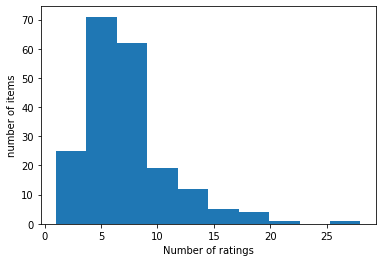

In [63]:
plt.hist(item_ratings)
plt.xlabel("Number of ratings")
plt.ylabel("number of items")

In [83]:
# Number of items with < 10 ratings
count_less_than_10 = np.count_nonzero(item_ratings<10)/len(item_ratings)*100

In [84]:
count_less_than_10

79.0

In [72]:
user_ratings = []
for user_id in ratings.columns:
    if user_id == 'item':
        continue
    user_id = str(user_id)
    user_ratings.append(len(get_ratings(user_id)))

Text(0, 0.5, 'number of users')

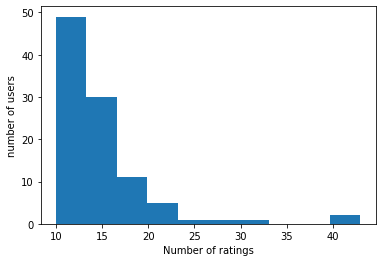

In [75]:
plt.hist(user_ratings)
plt.xlabel("Number of ratings")
plt.ylabel("number of users")

In [80]:
# Number of users with < 10 ratings
count_less_than_10 = np.count_nonzero(np.array(user_ratings)<10)/len(user_ratings)*100

In [81]:
count_less_than_10

0.0